Se cargan los datos desde keras, se normalizan las imagenes de modo que los pixeles queden descritos en el range [0,1], luegos se transforman en vectores unidimensionales y se parten en conjuntos disjuntos de entrenamiento, validación y prueba

In [1]:
from keras.datasets import mnist
import numpy as np
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255. #and x_test
x_test = x_test.astype('float32') / 255.
#Se extraen datos para hacer el set de validación
# print(x_train.shape)
# print(x_test.shape)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=(1/6))

print('datos de entrenamiento : '+str(x_train.shape))
print('datos de validacion : '+str(x_val.shape))
print('datos de pruebas : '+str(x_test.shape))

#como vector
Y_train = np_utils.to_categorical(y_train, 10)
Y_val = np_utils.to_categorical(y_val, 10)
Y_test = np_utils.to_categorical(y_test, 10)

Using TensorFlow backend.
/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


11493376/11490434 [==============================] - 24s 2us/step
datos de entrenamiento : (50000, 28, 28)
datos de validacion : (10000, 28, 28)
datos de pruebas : (10000, 28, 28)


Luego se pasa a usar los datos para una red de autoencoder feed forward, en donde las capas de este son densas. Para esto se re estructuraran los datos de entradas en forma de vector, es decir la matriz de 28 × 28 pasa a ser un vector de 784 componentes.

In [4]:
X_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
X_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
X_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(50000, 784)
(10000, 784)
(10000, 784)


#### Sección a) Se entrena un AE (1 hddn layer) para generar una representación de MNIST de d' = 2 ,8 ,32 ,64 . Se elije la función de perdida categorical_crossentropy   y el criterio del entrenamiento sigmoid . Determine el porcentaje de compresión obtneido y el error de reconstrucción en cada caso. Se mojra el resulta si elegiumos un funcióin de activación reulo para el encoder o decoder.

** revisar si binary-crossentroy o categorical (condiderando que trabaja con múltiples clases)

** Falta % de compresión, a que se refiere

In [ ]:
def model_a(c1,c2,name):
    ## Completar para mostrar distintos hist para graficar la perdida. 
    ## Mostrar la matriz de confusión para cada configuración
    ## sacar conclusiones
    

In [5]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
input_img = Input(shape=(784,))
encoded = Dense(32, activation='sigmoid')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input=input_img, output=decoded)
encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
##
autoencoder.compile(optimizer=SGD(lr=1.0), loss='categorical_crossentropy')
hist = autoencoder.fit(X_train,X_train,epochs=50,batch_size=32,validation_data=(X_val,X_val))
autoencoder.save('basic_autoencoder_768x32_sigmoid.h5')
#save other stuffs


/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys
/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  
/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 207us/step - loss: 591.2862 - val_loss: 578.5116
Epoch 2/50
50000/50000 [==============================] - 10s 200us/step - loss: 570.1969 - val_loss: 568.4323
Epoch 3/50
50000/50000 [==============================] - 10s 199us/step - loss: 559.3611 - val_loss: 556.8852
Epoch 4/50
50000/50000 [==============================] - 11s 222us/step - loss: 553.6512 - val_loss: 556.7777
Epoch 5/50
50000/50000 [==============================] - 11s 225us/step - loss: 552.0692 - val_loss: 553.4816
Epoch 6/50
50000/50000 [==============================] - 11s 215us/step - loss: 550.3885 - val_loss: 551.3231
Epoch 7/50
50000/50000 [==============================] - 10s 202us/step - loss: 548.4762 - val_loss: 549.2239
Epoch 8/50
50000/50000 [==============================] - 10s 203us/step - loss: 547.5388 - val_loss: 547.9952
Epoch 9/50
50000/50000 [==============================] - 10s 

KeyboardInterrupt: 

In [ ]:
input_img = Input(shape=(784,))
encoded = Dense(32, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input=input_img, output=decoded)
encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
##
autoencoder.compile(optimizer=SGD(lr=1.0), loss='categorical_crossentropy')
hist = autoencoder.fit(X_train,X_train,epochs=50,batch_size=32,validation_data=(X_val,X_val))
autoencoder.save('basic_autoencoder_768x32_eRelu.h5')

In [ ]:
input_img = Input(shape=(784,))
encoded = Dense(32, activation='sigmoid')(input_img)
decoded = Dense(784, activation='relu')(encoded)
autoencoder = Model(input=input_img, output=decoded)
encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
##
autoencoder.compile(optimizer=SGD(lr=1.0), loss='categorical_crossentropy')
hist = autoencoder.fit(X_train,X_train,epochs=50,batch_size=32,validation_data=(X_val,X_val))
autoencoder.save('basic_autoencoder_768x32_sRelu.h5')

In [ ]:
input_img = Input(shape=(784,))
encoded = Dense(32, activation='relu')(input_img)
decoded = Dense(784, activation='relu')(encoded)
autoencoder = Model(input=input_img, output=decoded)
encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
##
autoencoder.compile(optimizer=SGD(lr=1.0), loss='categorical_crossentropy')
hist = autoencoder.fit(X_train,X_train,epochs=50,batch_size=32,validation_data=(X_val,X_val))
autoencoder.save('basic_autoencoder_768x32_Relu.h5')

#### Sección b) Se comparan visialmente la reconstrucción que logra realizar el autoencoder. Determinar si la percepción visual se corresponde con el error de reconstrucción que se observa.

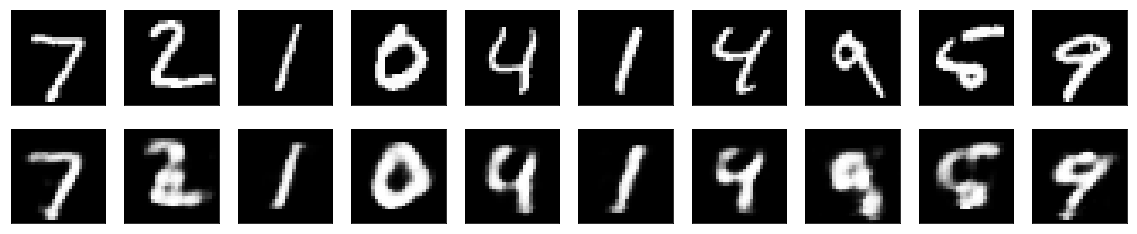

In [6]:
## verificar que encoder y decoder sean los mejores del punto anterior.
## mostra graficamente para las cuatro configuraciones del punto anterior
## seria interesante ver la imagen pequeña

from keras.models import load_model
autoencoder = load_model('basic_autoencoder_768x32.h5')
#load other stuff ...
encoded_test = encoder.predict(X_test)
decoded_test = decoder.predict(encoded_test)
import matplotlib
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Sección c) Se verifica la calidad de la representación obtenida, para ello se construye un clasificador kNN.

In [13]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
pca = PCA(n_components=10)
#PCA
pca.fit(X_train)
pca_train = pca.transform(X_train)
pca_test = pca.transform(X_test)
#AUTOENCODER
encoded_train = encoder.predict(X_train)
encoded_test = encoder.predict(X_test)
#CLASIFICATION
clf = KNeighborsClassifier(10)
clf.fit(pca_train, Y_train)
print ('Classification Accuracy PCA %.2f' % clf.score(pca_test,Y_test))
clf = KNeighborsClassifier(10)
clf.fit(encoded_train, Y_train)
print ('Classification Accuracy %.2f' % clf.score(encoded_test,Y_test))

Classification Accuracy PCA 0.90
Classification Accuracy 0.83


Falta colocar la conclusión de que AE es peor de KNN (sería interesante poder justificar porque?)

#### Sección d) Deep encoding, se experimenta el uso de más de dos capas ocultas para demostrar que mejora la compresión obtenida por PCA, utilizando el mismo número de dimensiones. Para ello se prueba con $d \in [2,4,8,16]$ y distintas profundidades $L \in [2,3,4]$ y se compara el desempeño tanto en el error de reconstrucción como en clasificación via kNN de cada representación

In [ ]:
target_dim = 2 #try other and do a nice plot
input_img = Input(shape=(784,))
encoded1 = Dense(1000, activation='relu')(input_img)
encoded2 = Dense(500, activation='relu')(encoded1)
encoded3 = Dense(250, activation='relu')(encoded2)
encoded4 = Dense(target_dim, activation='relu')(encoded3)
decoded4 = Dense(250, activation='relu')(encoded4)
decoded3 = Dense(500, activation='relu')(encoded3)
decoded2 = Dense(1000, activation='relu')(decoded3)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
autoencoder = Model(input=input_img, output=decoded1)
encoder = Model(input=input_img, output=encoded3)
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train,x_train,epochs=40,batch_size=32,validation_data=(x_val,x_val))
autoencoder.save('my_autoencoder_768x1000x500x250x2.h5')
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
pca = PCA(n_components=target_dim)
pca.fit(x_train)

In [ ]:
ver que configuración usar, con

#### Sección e) Se elije una de las representaciones anteriores y se visualizan usando la herramienta TSNE disponible en la librería sklearn. Para proceder con una comparación cualitativa de los resultados obtenidos mediante PCA y AE.

In [ ]:
nplot=5000 #warning: mind your memory!
encoded_train = encoder.predict(x_train[:nplot])
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in xrange(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)
pca_train = pca.transform(x_train)
encoded_train = pca_train[:nplot]
... #plot PCA


#### Sección f) Por ultimo se modifica el primer autoencoder (a) para trabajar directamente sobre las  imágenes de MNIST, sin tratarlas como vectores, sino como matrices de tamaño 1 x 28 x 28. Es posible utilizando capas convolucionales para definir el Encoder y el Decoder.

In [ ]:
X_train_ = x_train.astype('float32') / 255.
X_test_ = x_test.astype('float32') / 255.
X_train_ = np.reshape(x_train, (len(x_train), 28, 28, 1)) #modify for th dim ordering
X_test_ = np.reshape(x_test, (len(x_test), 28, 28, 1))
input_img_ = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img_)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()